In [1]:
%config Completer.use_jedi = False
import sys
sys.path.append('../')

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

imdb_df = pd.read_csv('./data/imdb_sampled/data-100samples.csv')
imdb_df.head(5)

,label,text,words
0,1,"Christian Duguay directed this tidy little espionage thriller early in his career. It plays on TV pretty regularly, albeit with some terrific scenes of violence and sex unfortunately trimmed. I finally got around to seeing the theatrical version on a $3 tape from the local video store. Naval officer Aidan Quinn is recruited to impersonate the notorious Carlos the Jackal, and gets a little too caught up in the role. Donald Sutherland Ben Kingsley play Quinn's superiors, with Sutherland a true zealot and Kingsley as the more level-headed one. The first half of this fun flick shows Quinn being trained and indoctrinated. The second half has him out in the field, making love to the Jackal's woman and shooting it out with sundry enemies. The idea is to make the Jackal look like a turncoat to the Russians, and let them take care of the world's most notorious assassin. Things don't exactly play out as planned. At times, I almost expected the cast to break out laughing at some of the corny dialogue, but they all play it very straight. In the end, this is one terrific little thriller that deserves your attention. The Jackal's former mistress teaching the highly proper and very married Quinn to rough her up, lick blood from her face, and then go down on her, alone is worth the price of admission.",227
1,1,"New Yorkers contemporaneous with this film will recall how reflective of its time it is and how well cast and crew captured America, New York City of that era.<br /><br />Norman Wexler's script delineates the different worlds the various sub groupings live in and Avildsen's direction brings out phenomenal performances all around. Peter Boyle's prodigious talent is on display as never before nor since. Clearly it is the best character portrayal the always likable Dennis Patrick ever accomplished.<br /><br />What I will always remember about JOE is the feeling of having been in a virtual state of shock coming out of the theater. Knowing that what the screen portrayed was seething under the surface in neighborhoods throughout the five boroughs of the City of New York.<br /><br />This film needs to be remembered.",133
2,0,"I love oddball animation, I love a lot of Asian films, but I didn't love this particular product of Japan. The Fuccons are supposedly an American family (they're all mannequins) who have moved to Japan, and they're somewhat a 50's sitcom type family, with slightly more modern sensibilities at times. The DVD features several very short episodes (like less than 5 minutes each?) and I did not find it to be either funny or entertaining, not even in a weird way. I'm not sure what the appeal is of this. I did pick up on some satire here and there, gosh, who wouldn't, but satire is usually somewhat humorous, isn't it? And nothing I saw or heard rated even a little smirk. I picked this up used and it certainly SOUNDED appealing, but I guess either I'm missing the point or it's just plain LAME. The box even says it's Fuccon hilarious, right there on the front, but I beg to differ. 2 out of 10.",166
3,1,"I have seen this film probably a dozen times since it was originally released theatrically. Anyone who calls this movie trash or horrible just doesn't understand action films or recognize a good one. Perhaps to some the incidents and outcomes may seem far fetched, but in my opinion screenwriter Shane Black ( Lethal Weapon/ Kiss Kiss Bang Bang) crafted one of the most well thought out action adventures you will ever come across. Over the top or not this film flows like clockwork and the action just keeps coming. The final action sequence is one of the best I have ever seen in any film. The cast in this film crackles. Genna Davis gave a tremendous performance and its a damn shame there was never a ""LKG"" sequel. Samuel L. Jackson is hilarious as her sidekick Mitch a down on his luck private eye trying to help her discover her lost past and make a few bucks. If Baffles me how anyone could not like this film. I

In [3]:
import re
import numpy as np
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def pre_proccess(text):
    text = text.lower()
    text = re.sub('["\',!-.:-@0-9/]()', ' ', text)
    return text

# Wrapper to adapt output format
class SentimentAnalisysModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __predict(self, text_input):
        text_preprocessed = pre_proccess(text_input)
        tokenized = self.tokenizer(text_preprocessed, padding=True, truncation=True, max_length=512, 
                                    add_special_tokens = True, return_tensors="pt")
        
        tensor_logits = self.model(**tokenized)
        prob = softmax(tensor_logits[0]).detach().numpy()
        pred = np.argmax(prob)
        
        return pred, prob
    
    def predict_label(self, text_inputs):
        return self.predict(text_inputs)[0]
        
    def predict_proba(self, text_inputs):
        return self.predict(text_inputs)[1]
        
    def predict(self, text_inputs):
        if isinstance(text_inputs, str):
            text_inputs = [text_inputs]
        
        preds = []
        probs = []

        for text_input in text_inputs:
            pred, prob = self.__predict(text_input)
            preds.append(pred)
            probs.append(prob[0])

        return np.array(preds), np.array(probs) # ([0, 1], [[0.99, 0.01], [0.03, 0.97]])

# Auxiliar function to load and wrap a model from Hugging Face
def load_model(model_name):
    print(f'Loading model {model_name}...')
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    return SentimentAnalisysModelWrapper(model, tokenizer)

# Hugging Face hosted model names 
imdb_models = {
    'bert': 'textattack/bert-base-uncased-imdb', 
    'albert': 'textattack/albert-base-v2-imdb', 
    'distilbert': 'textattack/distilbert-base-uncased-imdb', 
    'roberta': 'textattack/roberta-base-imdb', 
    'xlnet': 'textattack/xlnet-base-cased-imdb'
}

In [4]:
m1 = load_model(imdb_models['albert'])
m2 = load_model(imdb_models['distilbert'])
m3 = load_model(imdb_models['roberta'])
m4 = load_model(imdb_models['xlnet'])

# Models to be used as oracle
models = [m1, m2, m3, m4]
# Target model
model = load_model(imdb_models['bert'])

Loading model textattack/albert-base-v2-imdb...
Loading model textattack/distilbert-base-uncased-imdb...
Loading model textattack/roberta-base-imdb...


Some weights of the model checkpoint at textattack/roberta-base-imdb were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading model textattack/xlnet-base-cased-imdb...
Loading model textattack/bert-base-uncased-imdb...


In [5]:
from template_generator.instances import Instance, Sentence

In [6]:
# Sampling instances
np.random.seed(220)
n_instances = 100
df_sampled = imdb_df.sample(n_instances)

instances = [x for x in df_sampled['text'].values]
X = [Instance(instance) for instance in instances]

sentences = []
for x in X: sentences.extend(x.split_to_sentences())
print(len(sentences))

795


In [7]:
from template_generator.oracle_model import OracleModel
oracle = OracleModel(models)

In [8]:
predictions = oracle.predict_all(sentences)

Predicting inputs...


/tmp/ipykernel_1737/1179770237.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(tensor_logits[0]).detach().numpy()


In [9]:
lines = [[sent.original_text] for sent in sentences]
for line, preds in zip(lines, predictions):
    line.extend([pred.label for pred in preds])
    

In [10]:
df = pd.DataFrame(lines, columns=['text', 'albert', 'distilbert', 'roberta', 'xlnet'])
df['unanimous'] = df.apply(lambda x: x[1] == x[2] and x[2] == x[3] and x[3] == x[4], axis=1)

In [11]:
df[df['unanimous'] == False]

,text,albert,distilbert,roberta,xlnet,unanimous
1,"Kennedy was President-Elect.<br /><br />As for the episode, it was a passable episode, if not a bit earnest.",1,0,1,0,False
7,Sony's got the rights to Harry records -- you need to distribute the film and you'll get radically increased sales of his back catalog!,0,1,1,1,False
10,They were turning people away at the door!,0,0,1,1,False
11,"I went to many of the Mods & Rockers festival films, and let me assure you that no other film came even close to selling out, let alone turning people away.",0,1,0,1,False
21,Anyone who calls this movie trash or horrible just doesn't understand action films or recognize a good one.,1,0,1,0,False
...,...,...,...,...,...,...
789,I was a little upset because she wasn't a bride of a gorilla: she is now the wife of the gorilla.,1,1,0,1,False
790,She should have married him when he was a gorilla then the title would have made more sense.,0,1,0,0,False
791,There are all these people in the middle of the jungle too and they all want to leave.,1,1,1,0,False
792,"This isn't just a B movie, it's more like a Z movie.",0,0,1,1,False


In [13]:
def discord(x):
    if x[1] != x[2] and x[2] == x[3] and x[3] == x[4]:
        return 'albert'
    elif x[1] != x[2] and x[1] == x[3] and x[3] == x[4]:
        return 'distilbert'
    elif x[1] == x[2] and x[2] != x[3] and x[2] == x[4]:
        return 'roberta'
    elif x[1] == x[2] and x[2] == x[3] and x[3] != x[4]:
        return 'xlnet'
    else:
        return 'ambiguous'
    
df['discord'] = df.apply(lambda x: discord(x), axis=1)
df[df['unanimous'] == False]

,text,albert,distilbert,roberta,xlnet,unanimous,discord
1,"Kennedy was President-Elect.<br /><br />As for the episode, it was a passable episode, if not a bit earnest.",1,0,1,0,False,ambiguous
7,Sony's got the rights to Harry records -- you need to distribute the film and you'll get radically increased sales of his back catalog!,0,1,1,1,False,albert
10,They were turning people away at the door!,0,0,1,1,False,ambiguous
11,"I went to many of the Mods & Rockers festival films, and let me assure you that no other film came even close to selling out, let alone turning people away.",0,1,0,1,False,ambiguous
21,Anyone who calls this movie trash or horrible just doesn't understand action films or recognize a good one.,1,0,1,0,False,ambiguous
...,...,...,...,...,...,...,...
789,I was a little upset because she wasn't a bride of a gorilla: she is now the wife of the gorilla.,1,1,0,1,False,roberta
790,She should have married him when he was a gorilla then the title would have made more sense.,0,1,0,0,False,distilbert
791,There are all these people in the middle of the jungle too and they all want to leave.,1,1,1,0,False,xlnet
792,"This isn't just a B movie, it's more like a Z movie.",0,0,1,1,False,ambiguous


discord
ambiguous     104
xlnet          80
albert         43
roberta        37
distilbert     35
Name: count, dtype: int64


<Axes: xlabel='discord'>

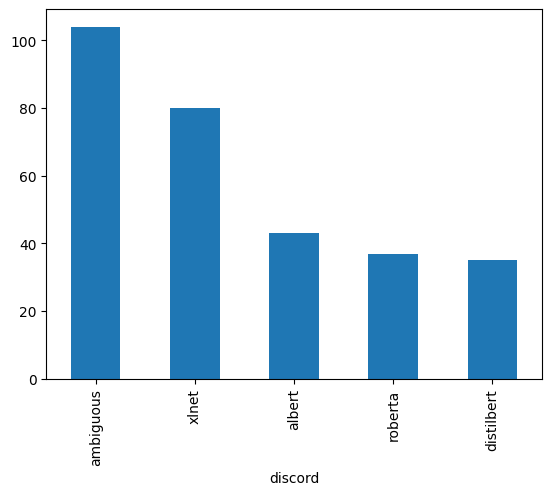

In [14]:
print(df[df['unanimous'] == False]['discord'].value_counts())
df[df['unanimous'] == False]['discord'].value_counts().plot.bar()

In [15]:
import collections

lbl_dict = collections.Counter([1,1,0,0])
min(lbl_dict, key=lbl_dict.get)


1